#Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

## Загрузка и проверка данных

Установка и подключение библиотек:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from torchsummary import summary

In [9]:
epochs = 20
learning_rate = 0.001
batch_size = 64

Загрузка CIFAR10:

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Размеры обучающей и тестовой выборки:

In [11]:
print(f'Обучающая выборка: {train_loader.dataset.data.shape}, ({len(train_loader.dataset.targets)})')
print(f'Тестовая выборка: {test_loader.dataset.data.shape}, ({len(test_loader.dataset.targets)})')

Обучающая выборка: (50000, 32, 32, 3), (50000)
Тестовая выборка: (10000, 32, 32, 3), (10000)


Проверим загруженные данные: выберем случайные изображения

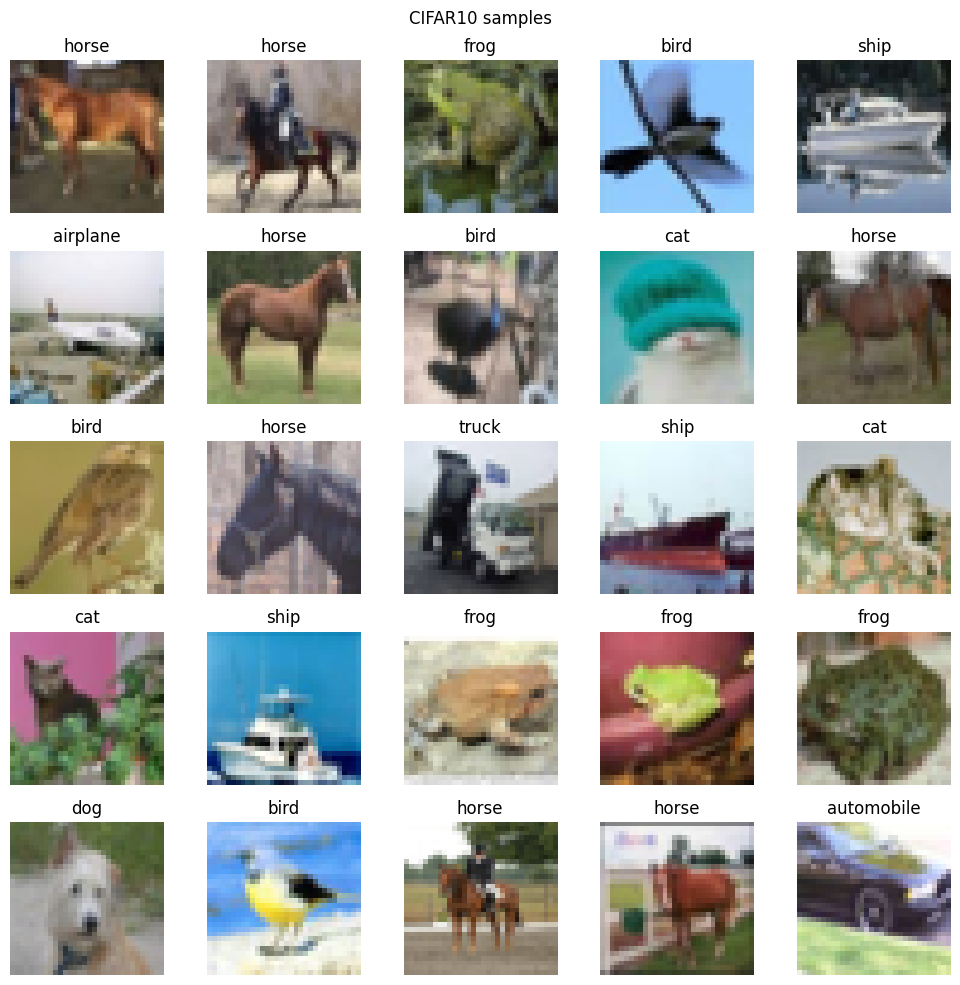

In [12]:
def draw_samples(loader, size = 5):
    fig, axs = plt.subplots(size, size, figsize=(10,10))
    indexes = np.random.randint(low=0, high=loader.dataset.data.shape[0], size=size*size)
    fig.suptitle("CIFAR10 samples")
    for i in range(size):
        for j in range(size):
            idx = indexes[i * size + j]
            axs[i, j].imshow(loader.dataset.data[idx],
                              cmap=plt.cm.binary)
            axs[i, j].axis('off')
            axs[i, j].set_title(loader.dataset.classes[loader.dataset.targets[idx]])
    plt.tight_layout()
    plt.show()

draw_samples(train_loader)

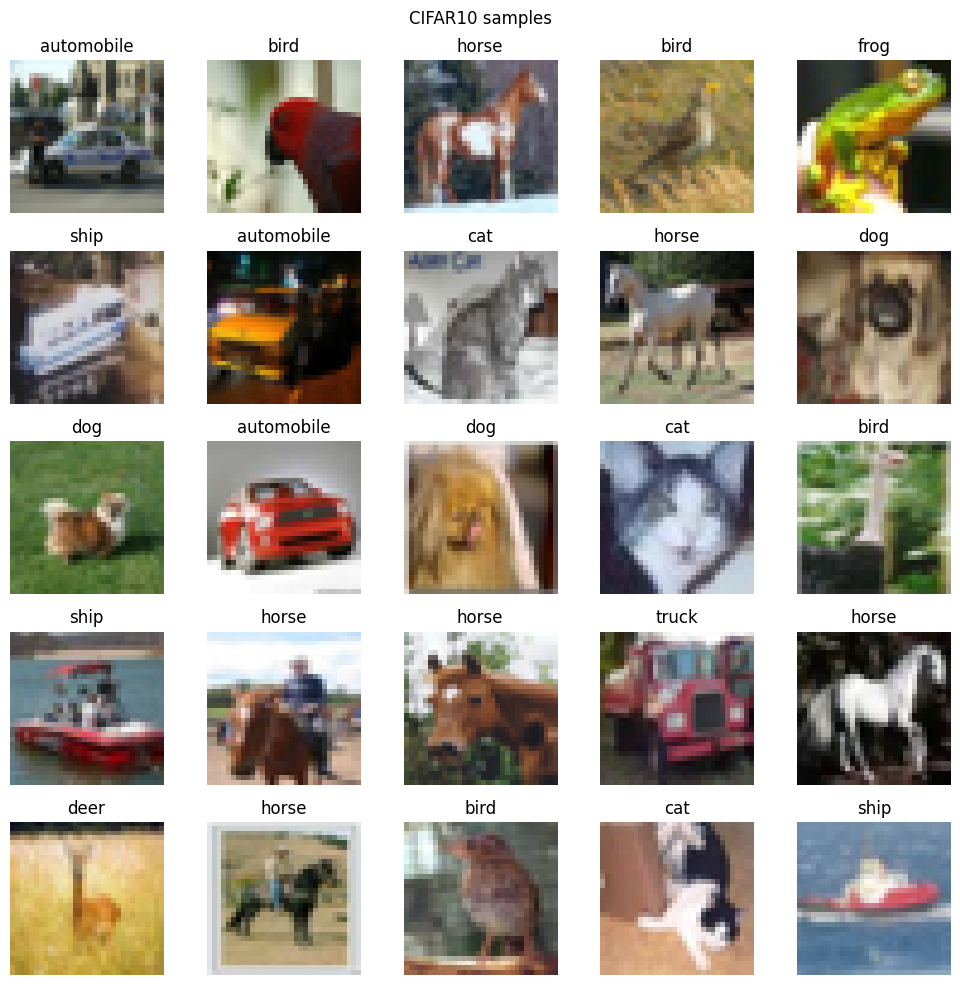

In [13]:
draw_samples(test_loader)

## Реализация нейронной сети

In [45]:
def block(input_channel_num, output_channel_num, is_pool):
    layers = [nn.Conv2d(input_channel_num, output_channel_num, kernel_size=3, padding=1),
              nn.BatchNorm2d(output_channel_num), nn.ReLU()]

    if is_pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class neural_network(nn.Module):
    def __init__(self, input_channel_num=3, output_channel_num=10):
        super(neural_network, self).__init__()
        self.layers1 = nn.Sequential(block(input_channel_num, 64, False),
                                     block(64, 64, False),
                                     block(64, 128, True),
                                     block(128, 128, False),
                                     block(128, 256, True),
                                     block(256, 256, False),
                                     block(256, 512, True),
                                     block(512, 512, False)
                                    )
        self.layers2 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    nn.Flatten(),
                                    nn.Dropout(0.1),
                                    nn.Linear(512, output_channel_num))

    def forward(self, x):
        y = self.layers1(x)
        y = self.layers2(y)
        return y

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = neural_network().to(device)
cross_entropy_loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
summary(model, (3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Обучение модели

In [47]:
train_loss = []
train_accuracy = []
for epoch in range(epochs):
    curr_accuracy = []
    curr_loss = []
    start = time.time()
    for data in train_loader:
        images = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        curr_loss.append(loss)
        curr_accuracy.append(torch.mean(torch.argmax(outputs, dim = 1) == labels, dtype = float))

    end = time.time()
    print(f'epoch: {epoch}, loss= {torch.stack(curr_loss).mean():.5f}, accuracy= {torch.stack(curr_accuracy).mean():.5f}, t= {(end - start):.2f} s')
    train_loss.append(torch.stack(curr_loss).mean().cpu().detach().numpy())
    train_accuracy.append(torch.stack(curr_accuracy).mean().cpu().detach().numpy())

epoch: 0, loss= 1.16671, accuracy= 0.57631, t= 24.00 s
epoch: 1, loss= 0.71354, accuracy= 0.75104, t= 24.31 s
epoch: 2, loss= 0.54025, accuracy= 0.81170, t= 24.19 s
epoch: 3, loss= 0.43371, accuracy= 0.84938, t= 24.14 s
epoch: 4, loss= 0.34667, accuracy= 0.87876, t= 24.21 s
epoch: 5, loss= 0.27363, accuracy= 0.90501, t= 24.18 s
epoch: 6, loss= 0.21186, accuracy= 0.92571, t= 24.17 s
epoch: 7, loss= 0.15662, accuracy= 0.94429, t= 24.09 s
epoch: 8, loss= 0.11757, accuracy= 0.95824, t= 24.09 s
epoch: 9, loss= 0.09728, accuracy= 0.96579, t= 24.14 s
epoch: 10, loss= 0.07882, accuracy= 0.97283, t= 24.12 s
epoch: 11, loss= 0.06467, accuracy= 0.97762, t= 24.15 s
epoch: 12, loss= 0.05733, accuracy= 0.98046, t= 24.07 s
epoch: 13, loss= 0.05187, accuracy= 0.98198, t= 24.08 s
epoch: 14, loss= 0.04543, accuracy= 0.98368, t= 24.07 s
epoch: 15, loss= 0.04337, accuracy= 0.98439, t= 24.17 s
epoch: 16, loss= 0.03956, accuracy= 0.98647, t= 24.14 s
epoch: 17, loss= 0.03486, accuracy= 0.98811, t= 24.08 s
ep

### График ошибки и точности после обучения

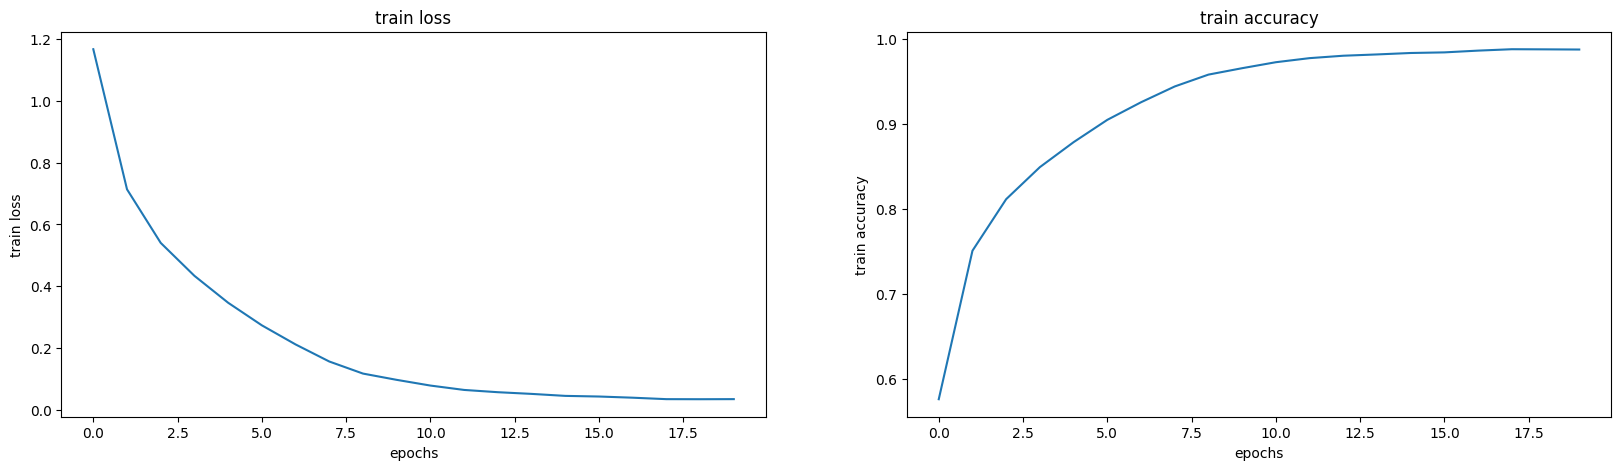

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].plot(train_loss)
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('train loss')
axs[0].set_title("train loss")

axs[1].plot(train_accuracy)
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('train accuracy')
axs[1].set_title("train accuracy")

plt.show()

## Тестирование модели

In [50]:
def test(loader):
    test_loss = 0
    test_accuracy = 0
    n = 0
    start = time.time()
    with torch.no_grad():
        for data in loader:
            images = data[0].to(device)
            labels = data[1].to(device)
            out = model(images)
            test_loss += cross_entropy_loss(out, labels)
            n += labels.size(0)
            _, predicted = torch.max(out.data, 1)
            test_accuracy += (predicted == labels).sum()
    end = time.time()
    print(f't= {(end - start):.2f} s, error= {test_loss / n:.5f}, accuracy= {test_accuracy / n:.5f}')

test(test_loader)

t= 3.49 s, error= 0.01035, accuracy= 0.86830
